## Neural Style Transfer 
## DD2424 Project based on : 'A Neural Algorithm of Artistic Style' Leon A. Gatys,Alexander S. Ecker,Matthias Bethge


### Import packages and libraries

In [166]:
import os 
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model

import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools

## Functions

In [179]:
#Load images and preprocess them to the correct shape
#def loadImg(path): 
 # x = tf.io.(path, target_size= (224, 224))
  #x = img_to_array(x)
  #x = np.expand_dims(x, axis=0)
  #x = preprocess_input(x)
  #return x
def loadImg(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  img = tf.image.resize(img, (224, 224))
  return img

def imShow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  
  if title:
    plt.title(title)

def vgg_model(layers): 
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layers]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)




In [180]:
# Check the compute loss function
loss_check = compute_loss(noise_style_features, noise_content_features, style_features, content_features)
print(type(loss_check))
print(loss_check)

InvalidArgumentError: Expected input 0 to have rank 4 but got: 2 [Op:Einsum]

## Prepare the model VGG19

In [169]:
#Following the method of the paper : we first import the VGG19-Network. The
#feature space provided by the 16 convolutional and 5 pooling layers of the 19 #layer VGGNetwork

VGG19 = tf.keras.applications.VGG19(include_top=False)

content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1','block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Extract features from content and style image

tf.Tensor(
[[[[0.00392157 0.00392157 0.01176471]
   [0.00028011 0.00756303 0.01176471]
   [0.         0.00784314 0.01176471]
   ...
   [0.00392157 0.00392157 0.00560207]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]]

  [[0.00392157 0.00392157 0.01176471]
   [0.00028011 0.00756303 0.01176471]
   [0.         0.00784314 0.01176471]
   ...
   [0.00392157 0.00392157 0.00560207]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]]

  [[0.00392157 0.00392157 0.01176471]
   [0.00028011 0.00756303 0.01176471]
   [0.         0.00784314 0.01116447]
   ...
   [0.00362148 0.00422166 0.00780301]
   [0.00392157 0.00392157 0.00652257]
   [0.00392157 0.00392157 0.00392157]]

  ...

  [[0.         0.00784314 0.01176471]
   [0.         0.00784314 0.00916374]
   [0.         0.00814325 0.00818333]
   ...
   [0.00308132 0.00476182 0.01176471]
   [0.00392157 0.00392157 0.01140449]
   [0.00392157 0.00392157 0.0067226 ]]

  [[0.         0.00784314 0.011764

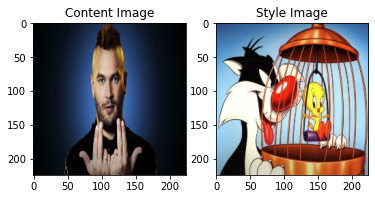

In [177]:
#Get the path of the pictures we want
content_path = tf.keras.utils.get_file('jul.jpg', 'https://img.lemde.fr/2020/11/18/494/0/8688/4340/1440/720/60/0/7d2c869_856070765-jul-fifou-0888.jpg')
style_path = tf.keras.utils.get_file('titiandgros.jpg', 'https://i.pinimg.com/564x/99/d3/21/99d321028e0803f9c928aadc78f934f8.jpg')

#Load them
content_img = loadImg(content_path)
style_img = loadImg(style_path)

plt.subplot(1,2,1)
print(content_img)
imShow(content_img, 'Content Image')
plt.subplot(1,2,2)
imShow(style_img, 'Style Image')

content_img = preprocess_input(content_img*255)
style_img = preprocess_input(style_img*255)

content_model = vgg_model(content_layers)
style_model = vgg_model(style_layers)

content_model.trainable = False
style_model.trainable = False

#Create the features map of both images
content_features = content_model(content_img)
style_features = style_model(style_img)

#Print shapes to debug
print ("Content features Size : ")
print(content_features.shape)
print('Style features Size : ')
for i in range(len(style_features)):
    print(style_features[i].shape)

## Extract features from the white noise image

'\nContent features Size : \n(1, 14, 14, 512)\nStyle features Size : \n(1, 224, 224, 64)\n(1, 112, 112, 128)\n(1, 56, 56, 256)\n(1, 28, 28, 512)\n(1, 14, 14, 512)\n\n'

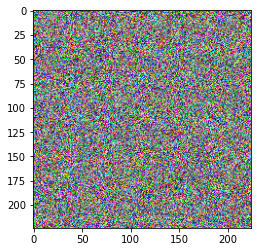

In [171]:
#noisy_image = np.random.uniform(0, 1, [1, 224, 224, 3])
#imShow(noisy_image)
#noisy_image = preprocess_input(noisy_image*255)

#Create the features map of both images

#noise_content_features = content_model(noisy_image)

#noise_style_features = style_model(noisy_image)


'''
Content features Size : 
(1, 14, 14, 512)
Style features Size : 
(1, 224, 224, 64)
(1, 112, 112, 128)
(1, 56, 56, 256)
(1, 28, 28, 512)
(1, 14, 14, 512)

'''


In [182]:
#style_targets =NOIfeatures.reshape((length,width))
#content_targets = noise_content_features.reshape((length,width))

# TF Optimizers

tf_noise_image = tf.Variable(content_img)
noise_content_features = content_model(tf_noise_image)
noise_style_features = style_model(tf_noise_image)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1 = 0.99, epsilon = 1e-1)

# a = compute_loss(noise_style_features,noise_content_features,style_features,content_features)

@tf.function()
def train_step(image,noise_style_features, noise_content_features, style_features,content_features):
  with tf.GradientTape() as tape:
    loss = style_content_loss(noise_style_features, noise_content_features, style_features, content_features)
  print(loss)
  print(image)
  grad = tape.gradient(loss, image)
  print(grad)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))


In [181]:
def style_content_loss(noise_style_features, noise_content_features, style_features, content_features):
    beta=1e-2
    alpha=1e4

    style_tensor_list = []
    for i in range(len(noise_style_features)):
        G = gram_matrix(noise_style_features[i])
        A = gram_matrix(style_features[i])
        a = tf.reduce_mean((G-A)**2) 
        style_tensor_list.append(a)

    style_loss = tf.add_n(style_tensor_list)
    style_loss *= beta / len(noise_style_features)

    content_tensor_list = []
    for i in range(len(noise_content_features)):
        a = tf.reduce_mean((noise_content_features[i]-content_features[i])**2) 
        content_tensor_list.append(a)

    content_loss = tf.add_n(content_tensor_list)
    content_loss *= beta / len(noise_content_features)
    loss = style_loss + content_loss
    return loss

In [176]:
train_step(tf_noise_image,noise_style_features, noise_content_features, style_features, content_features)


<class 'tensorflow.python.framework.ops.Tensor'> HERE
<class 'tensorflow.python.framework.ops.Tensor'> HERE
<class 'tensorflow.python.framework.ops.Tensor'> HERE
<class 'tensorflow.python.framework.ops.Tensor'> HERE
<class 'tensorflow.python.framework.ops.Tensor'> HERE
Tensor("add:0", shape=(), dtype=float32)
<tf.Variable 'Variable:0' shape=(1, 224, 224, 3) dtype=float32>
None


ValueError: in user code:

    <ipython-input-173-83f9e991d272>:22 train_step  *
        opt.apply_gradients([(grad, image)])
    C:\Users\Daniel Pérez Felipe\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:630 apply_gradients  **
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    C:\Users\Daniel Pérez Felipe\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\optimizer_v2\utils.py:75 filter_empty_gradients
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['Variable:0'].
